In [2]:
import os
import cv2
import numpy as np
from image_similarity_measures.quality_metrics import ssim, fsim, psnr
from shutil import copyfile
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# Function to calculate selected similarity measures
def calculate_similarity_metrics(img1, img2):
    # Ensure both images are (X, Y, 1)
    if len(img1.shape) == 2:
        img1 = np.expand_dims(img1, axis=-1)
    if len(img2.shape) == 2:
        img2 = np.expand_dims(img2, axis=-1)

    if img1.shape != img2.shape:
        raise ValueError(f"Image shapes are not the same: {img1.shape} vs {img2.shape}")

    metrics = {
        'ssim': ssim(img1, img2),
        'fsim': fsim(img1, img2),
        'psnr': psnr(img1, img2)
    }
    return metrics

# Function to convert white background to black
def convert_white_to_black_background(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Threshold the image to create a mask of the white background
    _, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    # Invert the mask to get the white background as 0
    mask_inv = cv2.bitwise_not(mask)
    # Create a black background image
    black_background = np.zeros_like(image)
    # Use the mask to combine the black background with the original image
    result = cv2.bitwise_or(black_background, black_background, mask=mask)
    result = cv2.bitwise_or(result, image, mask=mask_inv)
    return result

# Function to compute similarity score for a single pair
def compute_similarity_score(ct_image_path, hist_image_path):
    ct_img = cv2.imread(ct_image_path, cv2.IMREAD_GRAYSCALE)
    if ct_img is None:
        raise ValueError(f"Failed to load CT image: {ct_image_path}")
    resized_ct_img = cv2.resize(ct_img, (256, 256))  # Resize to a manageable size
    resized_ct_img = np.expand_dims(resized_ct_img, axis=-1)  # Ensure the image is (256, 256, 1)

    hist_img = cv2.imread(hist_image_path)
    if hist_img is None:
        raise ValueError(f"Failed to load Histology image: {hist_image_path}")
    hist_img = convert_white_to_black_background(hist_img)  # Convert white background to black
    hist_img_gray = cv2.cvtColor(hist_img, cv2.COLOR_BGR2GRAY)
    resized_hist_img = cv2.resize(hist_img_gray, (256, 256))  # Resize to a manageable size

    metrics = calculate_similarity_metrics(resized_ct_img, resized_hist_img)
    avg_score = np.mean([metrics['ssim'], metrics['fsim'], metrics['psnr']])  # Average of selected metric scores

    return (ct_image_path, hist_image_path, avg_score, metrics)

# Function to compute similarity scores for all pairs using parallel processing
def compute_similarity_scores(ct_images, histology_images):
    similarity_scores = []

    with ThreadPoolExecutor() as executor:
        futures = []
        for ct_image_path in ct_images:
            for hist_image_path in histology_images:
                futures.append(executor.submit(compute_similarity_score, ct_image_path, hist_image_path))

        for future in tqdm(futures, desc="Computing similarity scores"):
            try:
                result = future.result()
                similarity_scores.append(result)
            except Exception as e:
                print(f"Error computing similarity score: {e}")

    return similarity_scores

# Function to find the top n unique pairs
def find_top_n_pairs(similarity_scores, n):
    similarity_scores.sort(key=lambda x: x[2], reverse=True)  # Sort by average score in descending order
    selected_pairs = []
    used_ct_images = set()
    used_hist_images = set()

    for ct_image_path, hist_image_path, avg_score, metrics in similarity_scores:
        if len(selected_pairs) >= n:
            break
        if ct_image_path not in used_ct_images and hist_image_path not in used_hist_images:
            selected_pairs.append((ct_image_path, hist_image_path, avg_score, metrics))
            used_ct_images.add(ct_image_path)
            used_hist_images.add(hist_image_path)

    return selected_pairs

# Function to create pairs and save them in the paired directory
def save_paired_images(pairs, paired_path):
    for i, (ct_image_path, hist_image_path, avg_score, metrics) in enumerate(pairs, start=1):
        ct_image_name = os.path.basename(ct_image_path)
        hist_image_name = os.path.basename(hist_image_path)

        paired_ct_path = os.path.join(paired_path, f"p{i}_ct_{ct_image_name}")
        paired_hist_path = os.path.join(paired_path, f"p{i}_hist_{hist_image_name}")

        copyfile(ct_image_path, paired_ct_path)
        copyfile(hist_image_path, paired_hist_path)

        print(f"Pair {i}: CT Image {ct_image_name} is paired with Histology Image {hist_image_name}")
        print(f"Metrics: {metrics}")

# List all CT and Histology images
def list_images(ct_path, histology_path):
    ct_images = [os.path.join(ct_path, img) for img in os.listdir(ct_path) if img.endswith(('.tif', '.png'))]
    histology_images = [os.path.join(histology_path, img) for img in os.listdir(histology_path) if img.endswith('.jpg')]
    return ct_images, histology_images




In [3]:
from random import sample
# Paths
ct_path = "./example_CT_images/"   #'../datasets/ct_hist_scans_preproc/trainA'
histology_path = "../datasets/new_dataset_90kV/trainB"
paired_path = "./example_Paired_Images/single_image"
n = 1  # Specify the number of top pairs to select 

# Ensure the paired images directory exists
if not os.path.exists(paired_path):
    os.makedirs(paired_path)

# Main execution
ct_images, histology_images = list_images(ct_path, histology_path)
ct_images = [ct_images[0]]  # Ensuring it's a list with one element
#histology_images = sample(histology_images, 25)

similarity_scores = compute_similarity_scores(ct_images, histology_images)
print(similarity_scores)
top_pairs = find_top_n_pairs(similarity_scores, 1)
save_paired_images(top_pairs, paired_path)

Computing similarity scores: 100%|██████████| 1036/1036 [04:39<00:00,  3.71it/s]


[('./example_CT_images/Th24_PbRB-90kV-2-_rec00000338.tif', '../datasets/new_dataset_90kV/trainB\\ts17_EMA49_s01r01s07.jpg', 11.67787320344541, {'ssim': 0.683206317163045, 'fsim': 0.25950758365083954, 'psnr': 34.090905709522346}), ('./example_CT_images/Th24_PbRB-90kV-2-_rec00000338.tif', '../datasets/new_dataset_90kV/trainB\\ts17_EMA49_s01r02s01.jpg', 11.935749619882463, {'ssim': 0.693229560559605, 'fsim': 0.24715863108119104, 'psnr': 34.866860668006595}), ('./example_CT_images/Th24_PbRB-90kV-2-_rec00000338.tif', '../datasets/new_dataset_90kV/trainB\\ts17_EMA49_s01r02s02.jpg', 12.404740101523755, {'ssim': 0.7343591898771866, 'fsim': 0.2465165389771757, 'psnr': 36.2333445757169}), ('./example_CT_images/Th24_PbRB-90kV-2-_rec00000338.tif', '../datasets/new_dataset_90kV/trainB\\ts17_EMA49_s01r02s03.jpg', 12.494480709984083, {'ssim': 0.7508412917209495, 'fsim': 0.2505460563570949, 'psnr': 36.482054781874204}), ('./example_CT_images/Th24_PbRB-90kV-2-_rec00000338.tif', '../datasets/new_dataset

100 samplen -> herunterreduzieren (paar duplikate löschen)

chatgpt -> tmux python file mehrmals auführen
    python file mit argument als Bild
    gpu balancing

dann top 20 auswählen 

dataframe wo jedes Pair mit Scores gespeichert wird. 
liste sortieren

bestes auswählen
dann beste 10-20 von diesem bild auswählen (selbst entscheiden)

Script machen dass Dataframe erzeugt für 100 CT bilder mit allen histologischen Pairs (+ Scores)
Danach selbst alle Bilder mit top 20 durchgehen und pairs definieren

Computing similarity scores: 100%|██████████| 625/625 [02:35<00:00,  4.01it/s]
Pair 1: CT Image E9-5_13-03_50kV_A_Rec_E9-5_13-03_50kV_rec00000945.png is paired with Histology Image s03r02s08.jpg
Metrics: {'ssim': 0.825040640468761, 'fsim': 0.3559147212323144}
Pair 2: CT Image E9-5_13-03_50kV_A_Rec_E9-5_13-03_50kV_rec00001023.png is paired with Histology Image s04r02s06.jpg
Metrics: {'ssim': 0.8074190239931639, 'fsim': 0.35897011710714216}
Pair 3: CT Image E9-5_13-03_50kV_A_Rec_E9-5_13-03_50kV_rec00000733.png is paired with Histology Image s17r02s03.jpg
Metrics: {'ssim': 0.8034057914939216, 'fsim': 0.335732362009839}
Pair 4: CT Image E9-5_13-03_50kV_A_Rec_E9-5_13-03_50kV_rec00000678.png is paired with Histology Image s19r02s05.jpg
Metrics: {'ssim': 0.7960104858494153, 'fsim': 0.3408164647893072}
Pair 5: CT Image E9-5_13-03_50kV_B_Rec_E9-5_13-03_50kV_rec00001881.png is paired with Histology Image s05r02s08.jpg
Metrics: {'ssim': 0.7719039532498676, 'fsim': 0.34635774172962924}

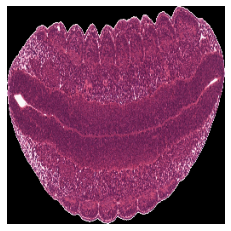

In [10]:
import cv2
import matplotlib.pyplot as plt

# Load the image
test_img = cv2.imread("./example_Paired_Images/single_image/p1_hist_ts17_EMA49_s03r02s01.jpg")

# Resize the image
test_img = cv2.resize(test_img, (256, 256))

# Save the image
cv2.imwrite("./test_img.jpg", test_img)

# Convert the image from BGR to RGB
test_img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Display the image using Matplotlib
plt.imshow(test_img_rgb)
plt.axis('off')  # Hide axis
plt.show()